# Plot point data in grid

Followed these useful guides.
- [Create fishnet](https://spatial-dev.guru/2022/05/22/create-fishnet-grid-using-geopandas-and-shapely/)
- [Gridding point data in python](https://james-brennan.github.io/posts/fast_gridding_geopandas/)

In [1]:
import os
import configparser

import geopandas as gpd
from shapely.geometry import Point, Polygon

import requests
import json
import pandas as pd

import matplotlib.pyplot as plt

#for colorbar
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib import colors
import numpy as np

from matplotlib import font_manager
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [2]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

In [3]:
# amend colour palette so that the highest value = given background colour
def get_colormap(hex_colors, bg_color, max_value):
    listed_colormap = colors.LinearSegmentedColormap.from_list('colorpalette', hex_colors, N=max_value) 
    bg_color = np.array(colors.to_rgba(bg_color))
    newcolors = listed_colormap(np.linspace(0, 1, max_value))
    cmap_new = colors.ListedColormap(np.vstack((bg_color, newcolors)))
    return cmap_new

## Create fishnet grid

In [4]:
# Read shapefile and reproject to coordinate system
london_all = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "london-shapefiles\\London_Borough_Excluding_MHW.shp"))
london_all = london_all.to_crs('EPSG:3857')

#join london boroughs into gdf to work with
london = gpd.GeoDataFrame({'geometry': london_all.unary_union,'index':[0]}, crs="EPSG:3857")

# Get the extent of the shapefile
total_bounds = london.total_bounds

# Get minX, minY, maxX, maxY
minX, minY, maxX, maxY = total_bounds

In [5]:
# Create a fishnet
x, y = (minX, minY)
geom_array = []

# Polygon Size (in meters)
square_size = 2000

while y <= maxY:
    while x <= maxX:
        geom = Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size
fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:3857')

#crop fishnet to london shapefile
fishnet = gpd.sjoin(fishnet, london, how='inner').reset_index(drop=True)
fishnet = fishnet.drop(columns=["index", "index_right"])

In [6]:
#save fishnet
fishnet.to_file(os.path.join(gdata_root, "fishnets\\london-2000-2000.geojson"))

(-61512.57733624599, 41887.422663754005, 6668475.62116162, 6749875.62116162)

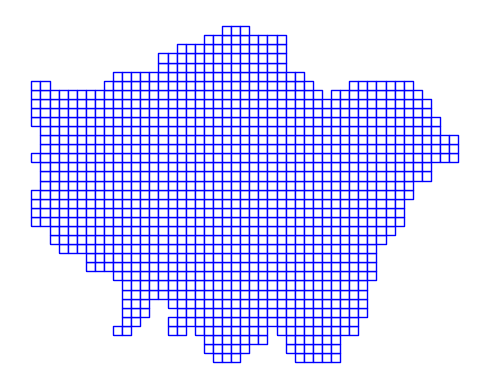

In [7]:
ax = fishnet.plot(color="white", edgecolor="blue")
ax.axis("off")

## Bus stops of London

In [78]:
#get data from OSM using Overpass API
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name="Greater London"][admin_level=5]->.searchArea;

(node["highway"="bus_stop"](area.searchArea); 
);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [94]:
#convert json into dataframe
df_dict = {"id":[], "type": [], "lat":[], "lon": [],"name":[], "bench":[]}

for element in data['elements']:
    df_dict["id"].append(element["id"])
    df_dict["type"].append(element["type"])
    
    for tag in ["name", "bench"]:
        try:
            df_dict[tag].append(element["tags"][tag])
        except KeyError:
            df_dict[tag].append("") 
    if element["type"]=="node":
        df_dict["lat"].append(element["lat"])
        df_dict["lon"].append(element["lon"])
    else:
        df_dict["lat"].append(element["center"]["lat"])
        df_dict["lon"].append(element["center"]["lon"])
        
df = pd.DataFrame.from_dict(df_dict)

# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)

In [144]:
#merge data
fishnet = fishnet.to_crs(4326)
merged = gpd.sjoin(gdf, fishnet, how='left')

# make a count variable that we can sum per grid cell
merged['busstops']=1
dissolve = merged.dissolve(by="index_right", aggfunc="count")

# include count in fishnet
fishnet.loc[dissolve.index, 'busstops'] = dissolve["busstops"].values

In [472]:
#dictionary of places to map
places = { "Liverpool St": [51.517633137766545, -0.08060437959423257],
          "Victoria": [51.495589500460675, -0.14321301504775705],
         }
places = pd.DataFrame.from_dict(places, orient="index", columns=["lat", "lon"])
geometry = [Point(xy) for xy in zip(places['lon'].astype(float), places['lat'].astype(float))]
places = gpd.GeoDataFrame(places, crs = "4326", geometry = geometry)
places

,lat,lon,geometry
Liverpool St,51.517633,-0.080604,POINT (-0.08060 51.51763)
Victoria,51.495590,-0.143213,POINT (-0.14321 51.49559)


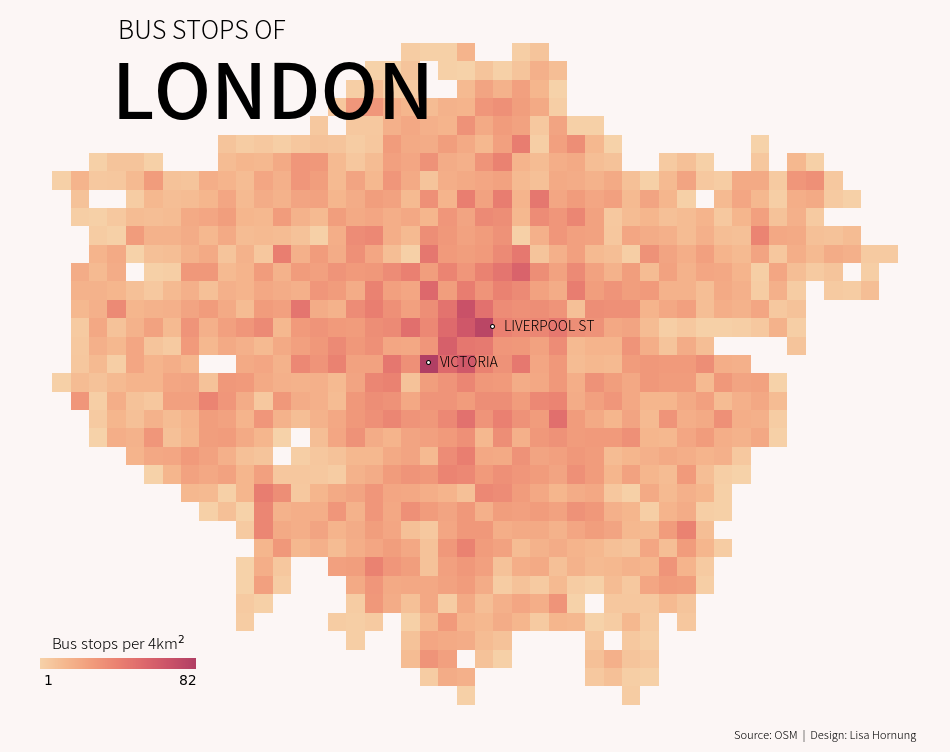

In [473]:
#configuration, colors and fonts
from palettable.cartocolors.sequential import RedOr_7
cmap=RedOr_7.mpl_colormap
bg_color = "#fcf6f5"
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\NotoSansTC-Medium.otf')
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\NotoSansTC-Light.otf')
label_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\NotoSansTC-Regular.otf')

#plot
fig, ax = plt.subplots(figsize=(12, 10))
fig.set_facecolor(bg_color)

# ===
# Data
values = "busstops"
fishnet.plot(ax=ax, column=values, alpha=1, zorder=1, cmap=cmap)
places.plot(ax=ax, markersize=8, color="white", edgecolor="black", linewidth=0.75)
for i in range(len(places)):
    ax.text(places["lon"][i]+0.012, places["lat"][i], places.index[i].upper(),
           fontproperties=subtitle_font, va="center_baseline", ha="left", fontsize=10)
ax.axis("off")

#====
#colorbar
cbaxes = fig.add_axes([0.15, 0.2, 0.13, 0.011]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=cmap)              
cb = plt.colorbar(cmappable, cax=cbaxes, anchor=(1,1.2), orientation='horizontal', drawedges=False,ticks=[0.05,0.95])
cb.set_ticklabels(["1", int(fishnet[values].max())])
cb.outline.set_visible(False)
cbaxes.tick_params(size=0)
cbaxes.text(0.5, 1.7, r"Bus stops per 4km$^2$", ha="center", fontproperties=subtitle_font, size=11, )

#====
# Text
plt.figtext(0.215, 0.88-0.05 , "Bus stops of".upper(), fontproperties=subtitle_font, fontsize=18,  ha="left")
plt.figtext(0.21, 0.8-0.05, "London".upper(), fontproperties=title_font, fontsize=55,  ha="left")
plt.figtext(0.88, 0.13, "Source: OSM  |  Design: Lisa Hornung", fontproperties=subtitle_font, fontsize=8, ha="right")

#export
plt.savefig("london-busstops.png", bbox_inches='tight', pad_inches=0.45, facecolor=bg_color, dpi=300)

plt.show()

## Places of culture in London

In [8]:
#get data from OSM using Overpass API
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name="Greater London"][admin_level=5]->.searchArea;

(node["amenity"~"arts_centre|theatre"](area.searchArea); 
way["amenity"~"arts_centre|theatre"](area.searchArea);
rel["amenity"~"arts_centre|theatre"](area.searchArea);
node["tourism"~"museum|gallery"](area.searchArea); 
way["tourism"~"museum|gallery"](area.searchArea);
rel["tourism"~"museum|gallery"](area.searchArea);
);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [9]:
#convert json into dataframe
df_dict = {"id":[], "type": [], "lat":[], "lon": [],"name":[], "tourism":[], "amenity":[]}

for element in data['elements']:
    df_dict["id"].append(element["id"])
    df_dict["type"].append(element["type"])
    
    for tag in ["name", "tourism", "amenity"]:
        try:
            df_dict[tag].append(element["tags"][tag])
        except KeyError:
            df_dict[tag].append("") 
    if element["type"]=="node":
        df_dict["lat"].append(element["lat"])
        df_dict["lon"].append(element["lon"])
    else:
        df_dict["lat"].append(element["center"]["lat"])
        df_dict["lon"].append(element["center"]["lon"])
        
df = pd.DataFrame.from_dict(df_dict)

# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)
gdf["art_type"] = gdf["tourism"] + gdf["amenity"]

In [10]:
#merge data
fishnet = fishnet.to_crs(4326)
merged = gpd.sjoin(gdf, fishnet, how='left')

# make a count variable that we can sum per grid cell
merged['arts']=1
dissolve = merged.dissolve(by="index_right", aggfunc="count")

# include count in fishnet
fishnet.loc[dissolve.index, 'arts'] = dissolve["arts"].values

In [11]:
#dictionary of places to map
places = {  "Covent Garden": [51.512928548426736, -0.12422115775554463]
         }
places = pd.DataFrame.from_dict(places, orient="index", columns=["lat", "lon"])
geometry = [Point(xy) for xy in zip(places['lon'].astype(float), places['lat'].astype(float))]
places = gpd.GeoDataFrame(places, crs = "4326", geometry = geometry)

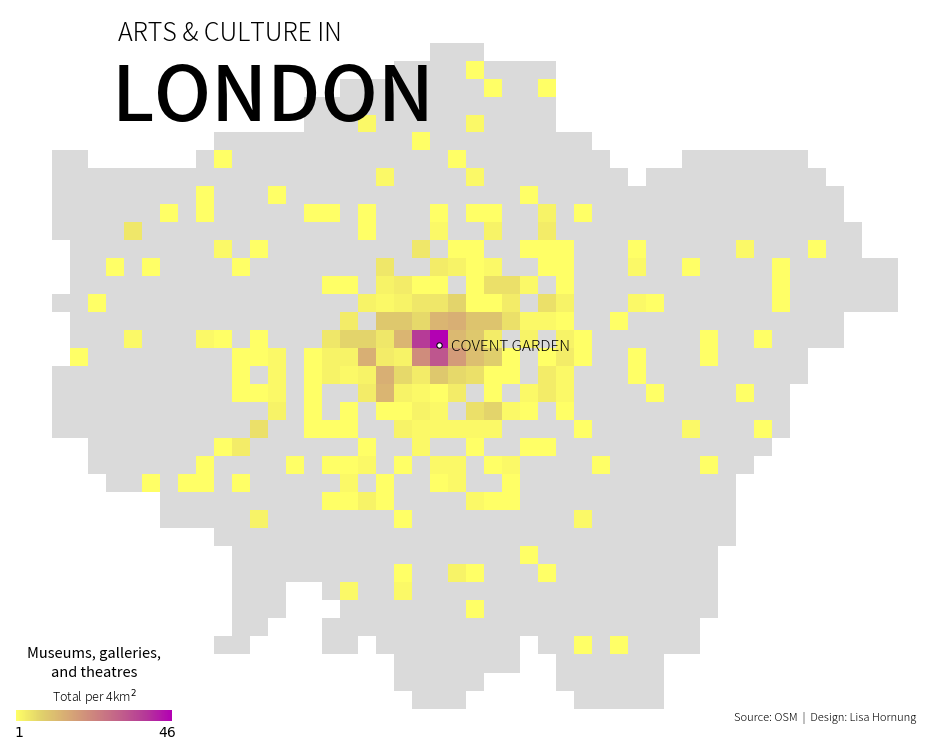

In [12]:
#configuration, colors and fonts
from palettable.scientific.sequential import Buda_7_r
cmap = Buda_7_r.mpl_colormap
bg_color = "white"

title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\NotoSansTC-Medium.otf')
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\NotoSansTC-Light.otf')
label_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\NotoSansTC-Regular.otf')

#plot
fig, ax = plt.subplots(figsize=(12, 10))
fig.set_facecolor(bg_color)

# ===
# Data
fishnet["arts_n"] = fishnet["arts"].fillna(0)
values = "arts"
fishnet.plot(ax=ax, column=values, alpha=1, zorder=3, cmap=cmap)
fishnet.plot(ax=ax, color="#DADADA",zorder=2)
places.plot(ax=ax, markersize=15, color="white", edgecolor="black", linewidth=0.75, zorder=3,)
for i in range(len(places)):
    ax.text(places["lon"][i]+0.012, places["lat"][i], places.index[i].upper(),
           fontproperties=subtitle_font, va="center_baseline", ha="left", fontsize=11)
ax.axis("off")

#====
#colorbar
cbaxes = fig.add_axes([0.13, 0.15, 0.13, 0.011]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=cmap)              
cb = plt.colorbar(cmappable, cax=cbaxes, anchor=(1,1.2), orientation='horizontal', drawedges=False,ticks=[0.02,0.97])
cb.set_ticklabels(["1", int(fishnet[values].max())])
cb.outline.set_visible(False)
cbaxes.tick_params(size=0)
cbaxes.text(0.5, 4, "Museums, galleries,\nand theatres", ha="center", fontproperties=label_font,size=10.5,
           linespacing=1.5)
cbaxes.text(0.5, 1.7, r"Total per 4km$^2$", ha="center", fontproperties=subtitle_font,size=9, )

#====
# Text
plt.figtext(0.215, 0.88-0.05 , "Arts & culture in".upper(), fontproperties=subtitle_font, fontsize=18,  ha="left")
plt.figtext(0.21, 0.8-0.05, "London".upper(), fontproperties=title_font, fontsize=55,  ha="left")
plt.figtext(0.88, 0.15, "Source: OSM  |  Design: Lisa Hornung", fontproperties=subtitle_font, fontsize=8, ha="right")

#export
plt.savefig("london-arts-culture.png", bbox_inches='tight', dpi=300, pad_inches=0.45, facecolor=bg_color)

plt.show()

## Arts and culture - playground

In [13]:
#calculate center of each grid cell in fishnet
fishnet = fishnet.to_crs(3857)
fishnet["center"] = fishnet["geometry"].centroid
gdf_arts = fishnet[fishnet["arts"]>=0]

In [15]:
import random
from palettable.mycarta import Cube1_6_r

#get random shape
shapes = [ "o", "s", "^", "D", "_", "|"]
random.choices(shapes, weights=(20, 20, 20, 20, 2,2), k=1)
gdf_arts["shape"] = random.choices(shapes, weights=(20, 20, 20, 20, 2,2), k=len(gdf_arts))

#get random colour
gdf_arts["colour"] = random.choices(Cube1_6_r.hex_colors, k=len(gdf_arts))
#colours = Cube1_6_r.hex_colors

C:\Users\lisa.hornung\anaconda3\envs\py3_map\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [16]:
# convert to new gdf with 'centroid' as the geometry
centroids = gpd.GeoDataFrame(gdf_arts.drop(columns="geometry"), geometry = "center")
centroids = centroids.to_crs(4326)

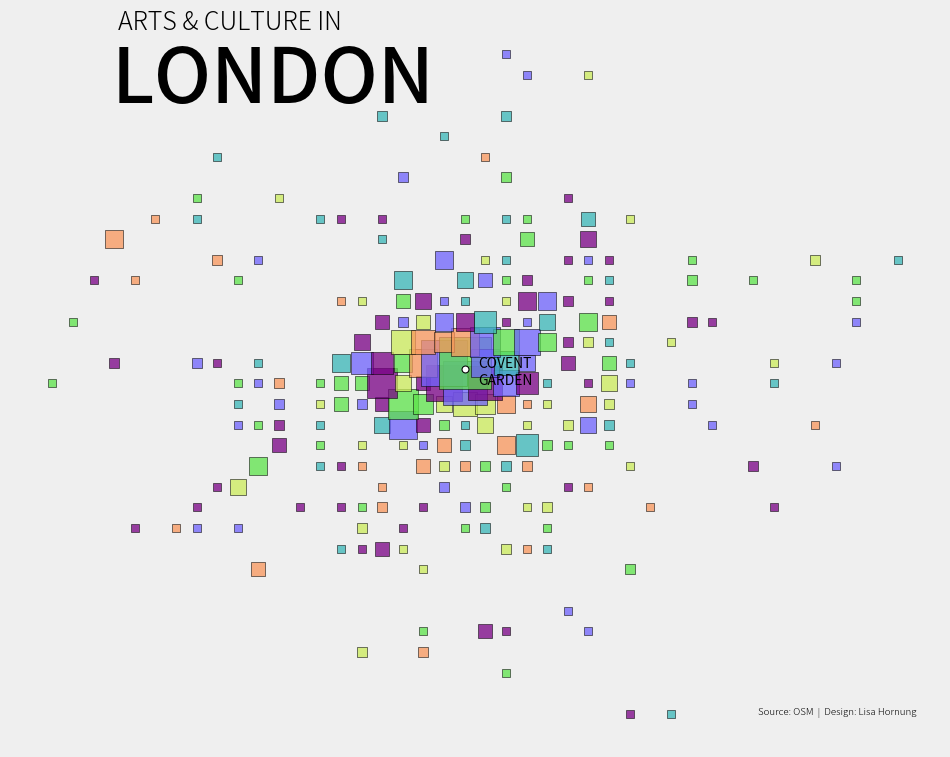

In [112]:
#plot
fig, ax = plt.subplots(figsize=(12, 12))

bg_color= "#EFEFEF"
fig.set_facecolor(bg_color)

# ===
# Data
for i in range(len(centroids)):
    ax.scatter(centroids["center"].x.iloc[i], centroids["center"].y.iloc[i],
               s=centroids["arts"].iloc[i]*30, marker="s", color=centroids["colour"].iloc[i], alpha=0.75, 
               edgecolor="black", clip_on=False, linewidth=0.5)

ax.axis("off")

#plot covent garden
places.plot(ax=ax, markersize=25, color="white", edgecolor="black", linewidth=0.75, zorder=3,)
for i in range(len(places)):
    ax.text(places["lon"][i]+0.012, places["lat"][i], "Covent\nGarden".upper(),
           fontproperties=label_font, va="center_baseline", ha="left", fontsize=10)

#====
# Text
plt.figtext(0.215, 0.86-0.07 , "Arts & culture in".upper(), fontproperties=subtitle_font, fontsize=18,  ha="left")
plt.figtext(0.21, 0.8-0.07, "London".upper(), fontproperties=title_font, fontsize=55,  ha="left")
plt.figtext(0.88, 0.22, "Source: OSM  |  Design: Lisa Hornung", fontproperties=subtitle_font, fontsize=7, ha="right")

#export
plt.savefig("london-arts-culture-creative.png", bbox_inches='tight', dpi=300, pad_inches=0.45, facecolor=bg_color)

plt.show()

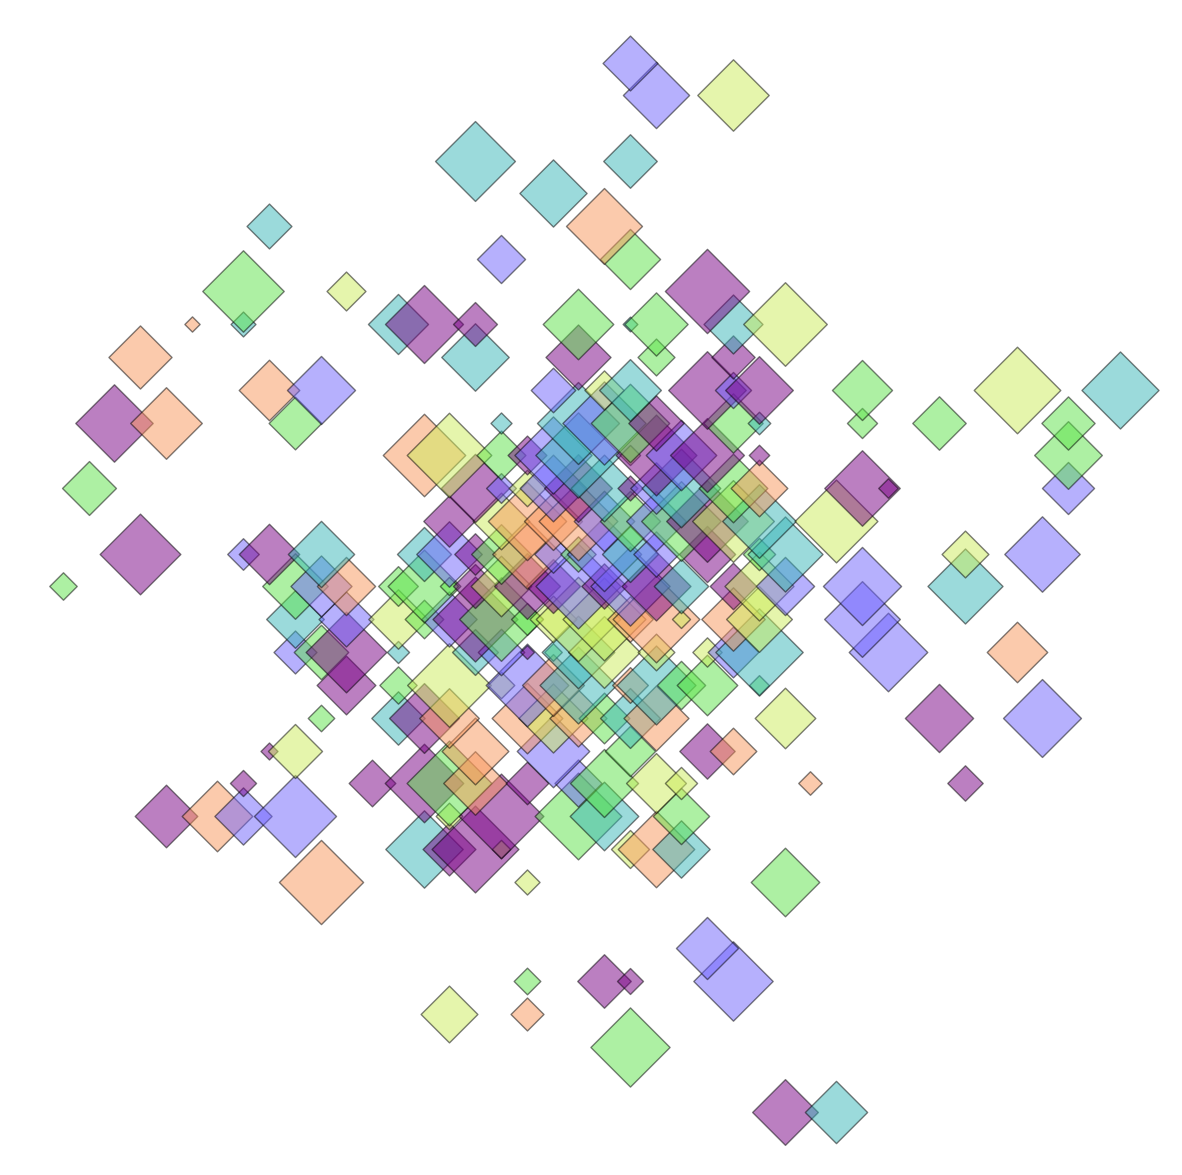

In [100]:

#plot
fig, ax = plt.subplots(figsize=(15, 15))
fig.set_facecolor(bg_color)

# ===
# Data
for i in range(len(centroids)):
    ax.scatter(centroids["center"].x.iloc[i], centroids["center"].y.iloc[i],
               s=random.randint(50, 2000), marker=random.choices(["D"], k=1)[0],
               color=centroids["colour"].iloc[i], alpha=0.5, 
               edgecolor="black", clip_on=False)

ax.axis("off")
plt.show()

Text(0.88, 0.15, 'Source: OSM  |  Design: Lisa Hornung')

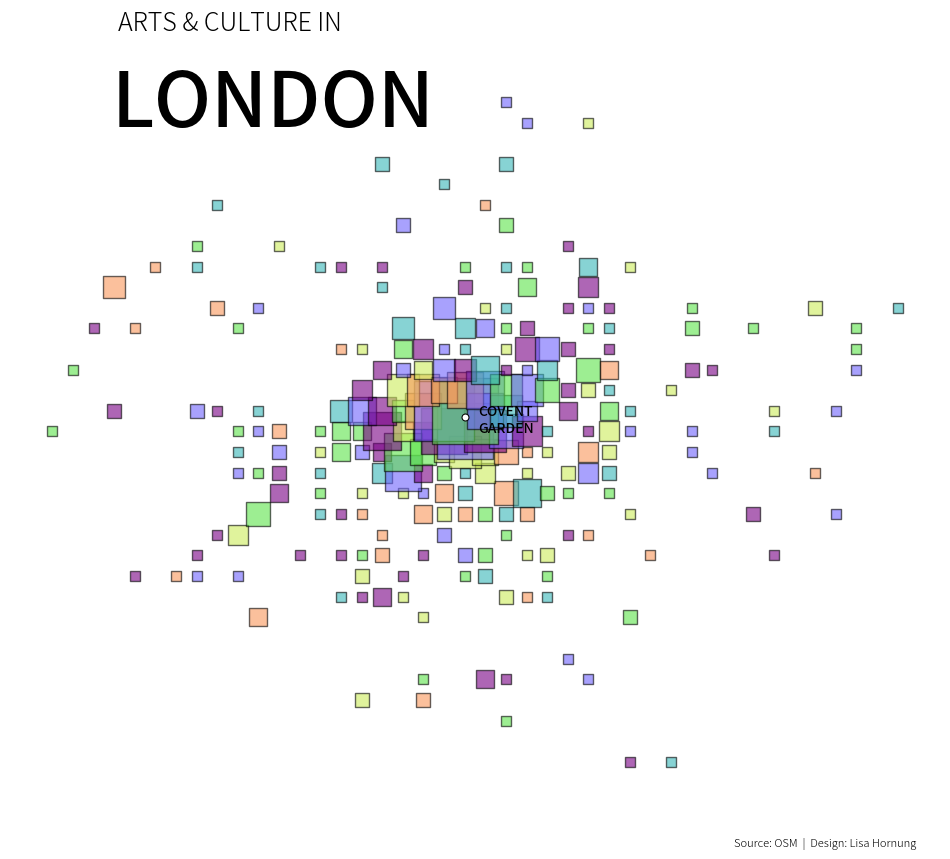

In [83]:

#plot
fig, ax = plt.subplots(figsize=(12, 12))
fig.set_facecolor(bg_color)

# ===
# Data
for i in range(len(centroids)):
    ax.scatter(centroids["center"].x.iloc[i], centroids["center"].y.iloc[i],
               s=centroids["arts"].iloc[i]*50, marker="s", color=centroids["colour"].iloc[i], alpha=0.6, 
               edgecolor="black", clip_on=False)

ax.axis("off")

#====
# Text
plt.figtext(0.215, 0.88-0.05 , "Arts & culture in".upper(), fontproperties=subtitle_font, fontsize=18,  ha="left")
plt.figtext(0.21, 0.8-0.05, "London".upper(), fontproperties=title_font, fontsize=55,  ha="left")
plt.figtext(0.88, 0.15, "Source: OSM  |  Design: Lisa Hornung", fontproperties=subtitle_font, fontsize=8, ha="right")

## Playground

In [238]:
#dictionary of places to map
places = {#"Waterloo": [51.503097240913284, -0.11528864470447049], 
          "Liverpool St": [51.517633137766545, -0.08060437959423257],
          "Victoria": [51.495589500460675, -0.14321301504775705],
          #"Kings Cross/St Pancras":[51.53069350299307, -0.12337523753758314],
          #"Croydon":[51.37721502506337, -0.0978625631770451],
          #"Lewisham":[51.46544888638621, -0.013238946295010654],
          #"Stratford":[51.544869143315154, -0.008621849266683095],
          #"Hackney Central":[51.547200599288225, -0.05676321616862555],
          #"Brixton":[51.46262071532086, -0.11483407356841145],
         # "Hounslow Central":[51.47121316795325, -0.3670742932023845],
          #"North Acton":[51.5236004700105, -0.25919538834877026],
          #"Kingston":[51.412638145195736, -0.3009380954518059],
            #"Tottenham Hale":[51.58900890206423, -0.06005115905305452],
          #"Walthamstow":[51.59026047959829, -0.020566122447518747],
       # "Hampstead Heath":[51.555036448994414, -0.16618473613118084]
          
         }
places = pd.DataFrame.from_dict(places, orient="index", columns=["lat", "lon"])

geometry = [Point(xy) for xy in zip(places['lon'].astype(float), places['lat'].astype(float))]
places = gpd.GeoDataFrame(places, crs = "4326", geometry = geometry)
places

,lat,lon,geometry
Liverpool St,51.517633,-0.080604,POINT (-0.08060 51.51763)
Victoria,51.495590,-0.143213,POINT (-0.14321 51.49559)


In [ ]:
#cmap = get_colormap(Buda_7_r.hex_colors, "#DADADA", int(fishnet["arts"].max()))

In [452]:
# played around with quite a few colour palettes before settling on one
from palettable.cartocolors.sequential import Magenta_7, PurpOr_5, Sunset_5, Teal_7, agGrnYl_5_r, BrwnYl_7, PinkYl_7, RedOr_7
from palettable.cmocean.sequential import Deep_14, Matter_20, Dense_20, Dense_5, Haline_10_r
from palettable.matplotlib import Magma_20_r
from palettable.scientific.sequential import Buda_7_r, Tokyo_8_r
from palettable.mycarta import Cube1_6_r